In [26]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import json
from pprint import pprint



In [32]:
mandelbrot32 = []
mandelbrot64 = []
simd32 = []
simd64 = []

json_path="./simdData/mandelbrotsimd.json"
with open(json_path) as f:
    data = json.load(f)

for d in data["datapoints"]:
    s = d["setting"]
    avg_time = list(map(lambda x: (x["computationTime"], x["iterationCount"], x["pixelCount"]),
                   sorted(d["data"]["workers"], key=lambda x: x["rank"])))
    #avg_time = np.average(avg_time)
    #if s["implementation"] == "mandelbrot32":
     #   mandelbrot32.extend(avg_time)
    #elif s["implementation"] == "mandelbrot64":
     #   mandelbrot64.extend(avg_time)
    if s["implementation"] == "mandelbrotsimd32":
        simd32.extend(avg_time)
    elif s["implementation"] == "mandelbrotsimd64":
        simd64.extend(avg_time)

json_path="./simdData/mandelbrotnosimd.json"
with open(json_path) as f:
    data = json.load(f)
for d in data["datapoints"]:
    s = d["setting"]
    avg_time = list(map(lambda x: (x["computationTime"], x["iterationCount"], x["pixelCount"]),
                   sorted(d["data"]["workers"], key=lambda x: x["rank"])))
    #avg_time = np.average(avg_time)
    if s["implementation"] == "mandelbrot32":
        mandelbrot32.extend(avg_time)
    elif s["implementation"] == "mandelbrot64":
        mandelbrot64.extend(avg_time)
    #elif s["implementation"] == "mandelbrotsimd32":
     #   simd32.extend(avg_time)
    #elif s["implementation"] == "mandelbrotsimd64":
     #   simd64.extend(avg_time)

        # Problem: Sometimes, ranks are missing!
        # solution: sort by itcount, only select entries with common itcount

print(len(mandelbrot32))
print(len(mandelbrot64))
print(len(simd32))
print(len(simd64))

288
288
288
288


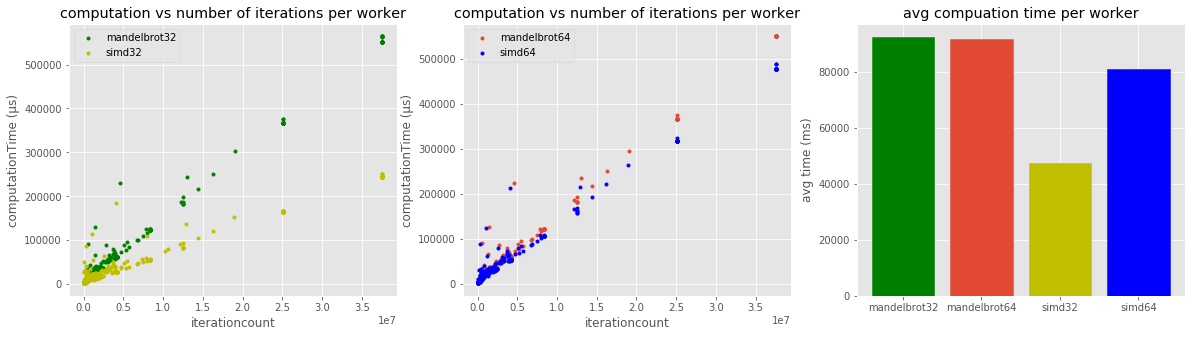

In [33]:
# Data for plotting
x = np.arange(len(simd64))
names = ["mandelbrot32", "mandelbrot64", "simd32", "simd64"]

plt.style.use('ggplot')
fig, (line32, line64, bar) = plt.subplots(1, 3, figsize=(20,5))

comp32, it32, pix32 = zip(*mandelbrot32)
p0 = line32.plot(list(it32), list(comp32), label=names[0], lw=0, marker=".",color="g")
comp64, it64, pix64 = zip(*mandelbrot64)
p1 = line64.plot(list(it64), list(comp64), label=names[1], lw=0, marker=".")
compsimd32, itsimd32, pixsimd32 = zip(*simd32)
p2 = line32.plot(list(itsimd32), list(compsimd32), label=names[2], lw=0, marker=".",  color="y")
compsimd64, itsimd64, pixsimd64 = zip(*simd64)
p3 = line64.plot(list(itsimd64), list(compsimd64), label=names[3], lw=0, marker=".",  color="b")
line32.legend()
line64.legend()

line32.set(xlabel='iterationcount', ylabel='computationTime (µs)',
       title='computation vs number of iterations per worker')
line64.set(xlabel='iterationcount', ylabel='computationTime (µs)',
       title='computation vs number of iterations per worker')
line32.grid(True)
line64.grid(True)

avg = np.asarray([np.average(comp32), np.average(comp64), np.average(compsimd32), np.average(compsimd64)])
x_avg = np.arange(len(avg))

barlist = bar.bar(x_avg, avg)
# set colors of bars to match colors in line plot
#TODO this bar graph 3 times: worst 25%, average 50%, best 25%
barlist[0].set_color(p0[0].get_color())
barlist[1].set_color(p1[0].get_color())
barlist[2].set_color(p2[0].get_color())
barlist[3].set_color(p3[0].get_color())

bar.set_xticks(x_avg)
bar.set_xticklabels(names)
bar.set(ylabel="avg time (ms)",
       title="avg compuation time per worker")
bar.grid(True)

# fig.savefig("impl_test.svg", format="svg")
plt.show()

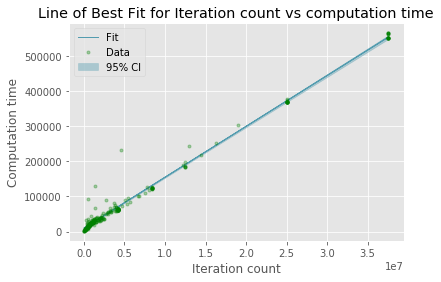

In [15]:
# Perform linear regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
import pandas as pd
x = sm.add_constant(it32)
y = comp32
regr = sm.OLS(y, x)
res = regr.fit()
# Get fitted values from model to plot
st, data, ss2 = summary_table(res, alpha=0.05)
fitted_values = data[:,2]

# Get the confidence intervals of the model
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

# Data for regions where we want to shade to indicate the intervals has
# to be sorted by the x axis to display correctly
CI_df = pd.DataFrame(columns = ['x_data', 'low_CI', 'upper_CI'])
CI_df['x_data'] = it32
CI_df['low_CI'] = predict_mean_ci_low
CI_df['upper_CI'] = predict_mean_ci_upp
CI_df.sort_values('x_data', inplace = True)

# Define a function for the line plot with intervals
def lineplotCI(x_data, y_data, sorted_x, low_CI, upper_CI, x_label, y_label, title):
    # Create the plot object
    _, ax = plt.subplots()

    # Plot the data, set the linewidth, color and transparency of the
    # line, provide a label for the legend
    ax.plot(x_data, y_data, lw = 1, color = '#539caf', alpha = 1, label = 'Fit')
    # Shade the confidence interval
    ax.fill_between(sorted_x, low_CI, upper_CI, color = '#539caf', alpha = 0.4, label = '95% CI')
    ax.plot(x_data, comp32, lw=0, color = 'g', alpha = 0.3, label = 'Data', marker='.')
    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Display legend
    ax.legend(loc = 'best')

# Call the function to create plot
lineplotCI(x_data = it32
           , y_data = fitted_values
           , sorted_x = CI_df['x_data']
           , low_CI = CI_df['low_CI']
           , upper_CI = CI_df['upper_CI']
           , x_label = 'Iteration count'
           , y_label = 'Computation time'
           , title = 'Line of Best Fit for Iteration count vs computation time')

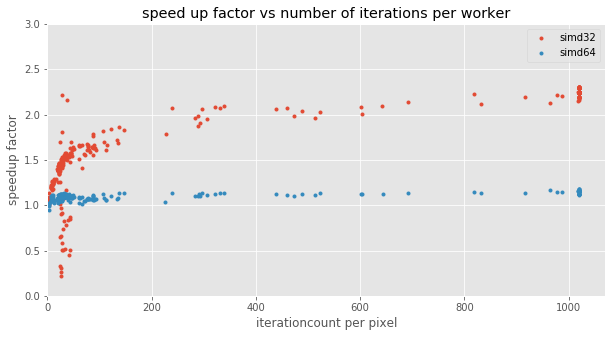

In [55]:
plt.style.use('ggplot')
# TODO this graph and the two below in one figure

fig, (line) = plt.subplots(1, 1, figsize=(10,5))
speedup32 = (np.asarray(comp32)/np.asarray(compsimd32))
speedup64 = (np.asarray(comp64)/np.asarray(compsimd64))
p0 = line.plot(np.asarray(it32)/np.asarray(pix32), speedup32, label=names[2], lw=0, marker=".")
p1 = line.plot(np.asarray(it64)/np.asarray(pix64), speedup64, label=names[3], lw=0, marker=".")
line.legend()

line.set(xlabel='iterationcount per pixel', ylabel='speedup factor',
       title='speed up factor vs number of iterations per worker')
line.grid(True)
line.axis([0, None, 0, 3])

plt.show()


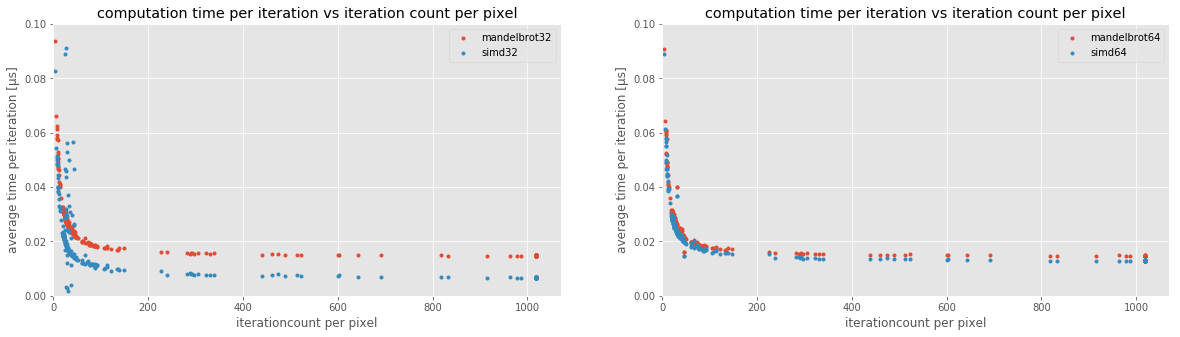

In [59]:
plt.style.use('ggplot')

fig, (line32, line64) = plt.subplots(1, 2, figsize=(20,5))

x32 = np.asarray(it32)/np.asarray(pix32)
x64 = np.asarray(it64)/np.asarray(pix64)

cpi32 = (np.asarray(comp32)/np.asarray(it32))
cpisimd32 = (np.asarray(compsimd32)/np.asarray(it32))
cpi64 = (np.asarray(comp64)/np.asarray(it32))
cpisimd64 = (np.asarray(compsimd64)/np.asarray(it32))

p0 = line32.plot(x32, cpi32, label=names[0], lw=0, marker=".")
p1 = line32.plot(x32, cpisimd32, label=names[2], lw=0, marker=".")
p2 = line64.plot(x64, cpi64, label=names[1], lw=0, marker=".")
p3 = line64.plot(x64, cpisimd64, label=names[3], lw=0, marker=".")
line32.legend()
line64.legend()

line32.set(xlabel='iterationcount per pixel', ylabel='average time per iteration [µs]',
       title='computation time per iteration vs iteration count per pixel')
line64.set(xlabel='iterationcount per pixel', ylabel='average time per iteration [µs]',
       title='computation time per iteration vs iteration count per pixel')
line32.grid(True)
line32.axis([0, None, 0, 0.1])
line64.grid(True)
line64.axis([0, None, 0, 0.1])

plt.show()